# Resume Classification Using Text Mining

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV,RandomSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
# ML classifier model Evaluation
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

np.random.seed(1)

## Exploratory Data Analysis


### Loading the dataset

In [3]:
df = pd.read_csv("Resume.csv")
df.head(3)

ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR

In [4]:
# Getting the information available
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


In the above we have 4 columns such as ID, Resume_str, Resume_html, and Category. Category columns are our target columns, and the rest of the target columns are used to train the model.

In [5]:
# Check how much data is available
df.shape

(2484, 4)

In [6]:
# To check how many categories are in the Categories columns
df['Category'].unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [7]:
# Check how many resume are available in every category.
df['Category'].value_counts()

INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: Category, dtype: int64

In [8]:
len(df['Category'].value_counts())

24

Out of 24 different categories, BUSINESS-DEVELOPMENT and INFORMATION-TECHNOLOGY class is the largest class with 120 resumes, whereas BPO class is the smallest with only 22 resumes. We have 118 resumes in some classes. Our goal is to develop a machine learning classifier which is going to correctly predict the class of an applicant's resume. Since we have 24 different categories, we will develop a multi-class classification algorithm.

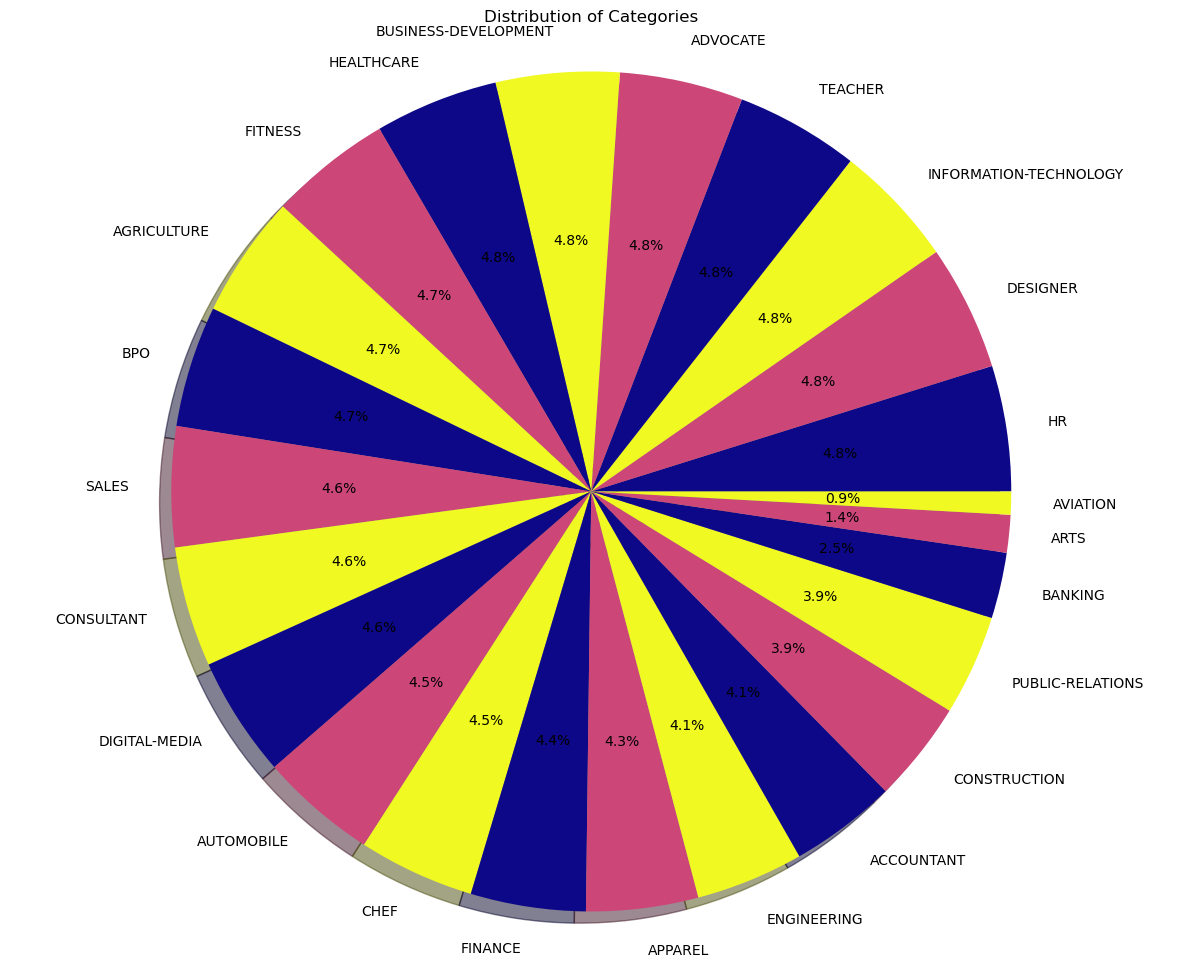

In [9]:
# create pie plot

counts=df['Category'].value_counts()
labels=df['Category'].unique()

plt.figure(figsize=(15,12))
plt.pie(counts,labels= labels, autopct='%1.1f%%',shadow=True, colors=plt.cm.plasma(np.linspace(0,1,3)))
plt.title('Distribution of Categories')
plt.axis('equal')  
plt.show()

### Handling Missing Values

In [10]:
# Check for missing values
df.isnull().sum()

ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64

In [11]:
# If there were missing values:
df['Category'].fillna('missing', inplace=True)

In [12]:
# Check resume data in 'Resume_str' column to see the text cleaning approach
# Print the content of the first row in the 'Resume_str' column
print(df['Resume_str'][0])

         HR ADMINISTRATOR/MARKETING ASSOCIATE

HR ADMINISTRATOR       Summary     Dedicated Customer Service Manager with 15+ years of experience in Hospitality and Customer Service Management.   Respected builder and leader of customer-focused teams; strives to instill a shared, enthusiastic commitment to customer service.         Highlights         Focused on customer satisfaction  Team management  Marketing savvy  Conflict resolution techniques     Training and development  Skilled multi-tasker  Client relations specialist           Accomplishments      Missouri DOT Supervisor Training Certification  Certified by IHG in Customer Loyalty and Marketing by Segment   Hilton Worldwide General Manager Training Certification  Accomplished Trainer for cross server hospitality systems such as    Hilton OnQ  ,   Micros    Opera PMS   , Fidelio    OPERA    Reservation System (ORS) ,   Holidex    Completed courses and seminars in customer service, sales strategies, inventory control, loss preve

Now, we can see that there are unnecessary elements in the text data, including dots, commas, excessive spaces, consecutive underscores, links, numbers, and other extraneous characters.

### Cleaning the Data (Text Cleaning)

1. Dropping the unwanted columns.
2. Converting characters to lowercases.
3. Removing punctuations, numbers, links, and foreign languages.
4. Lemmatization and remove stop words

In [13]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\meena\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\meena\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\meena\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [15]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # remove URLs
    text = re.sub('http\S+\s*', ' ', text) 
    # remove RT and cc
    text = re.sub('RT|cc', ' ', text)  
    # remove hashtags
    text = re.sub('#\S+', '', text)  
    # remove mentions
    text = re.sub('@\S+', '  ', text) 
    # remove extra whitespace
    text = re.sub('\s+', ' ', text)  
    # Tokenization
    tokens = word_tokenize(text)
    # Lemmatization and remove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['processed_text'] = df['Resume_str'].apply(preprocess_text)

df.head(3)

ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   

                                         Resume_html Category  \
0  <div class="fontsize fontface vmargins hmargin...       HR   
1  <div class="fontsize fontface vmargins hmargin...       HR   
2  <div class="fontsize fontface vmargins hmargin...       HR   

                                      processed_text  
0  hr administratormarketing associate hr adminis...  
1  hr specialist u hr operation summary versatile...  
2  hr director summary year experience recruiting...

In [16]:
## checking any rows are empty or not after cleaning procedure and dropping it
empty_rows = df[df['processed_text'] == '']
#df = df.drop(empty_rows.index)

print(empty_rows)

           ID             Resume_str  \
656  12632728                          

                                           Resume_html              Category  \
656  <div class="fontsize fontface vmargins hmargin...  BUSINESS-DEVELOPMENT   

    processed_text  
656                 


In [17]:
# Drop Resume_str' and "Resume_html" columns
df= df.drop(['Resume_str', 'Resume_html'], axis=1)

# Drop the rows with empty cleaned text
df = df.drop(empty_rows.index)

# After cleaning the text and dropping the unwanted colums
df.processed_text[0]

'hr administratormarketing associate hr administrator summary dedicated customer service manager year experience hospitality customer service management respected builder leader customerfocused team strives instill shared enthusiastic commitment customer service highlight focused customer satisfaction team management marketing savvy conflict resolution technique training development skilled multitasker client relation specialist omplishments missouri dot supervisor training certification certified ihg customer loyalty marketing segment hilton worldwide general manager training certification omplished trainer cross server hospitality system hilton onq micros opera pm fidelio opera reservation system or holidex completed course seminar customer service sale strategy inventory control loss prevention safety time management leadership performance assessment experience hr administratormarketing associate hr administrator dec current company name city state help develop policy directs coordi

In [18]:
# create list of all categories
categories = np.sort(df['Category'].unique())
categories

array(['ACCOUNTANT', 'ADVOCATE', 'AGRICULTURE', 'APPAREL', 'ARTS',
       'AUTOMOBILE', 'AVIATION', 'BANKING', 'BPO', 'BUSINESS-DEVELOPMENT',
       'CHEF', 'CONSTRUCTION', 'CONSULTANT', 'DESIGNER', 'DIGITAL-MEDIA',
       'ENGINEERING', 'FINANCE', 'FITNESS', 'HEALTHCARE', 'HR',
       'INFORMATION-TECHNOLOGY', 'PUBLIC-RELATIONS', 'SALES', 'TEACHER'],
      dtype=object)

#### Bar Chart
The bar chart shows the number of records for each category, where class imbalanced is spotted easily. BPO, AUTOMOBILE and AGRICULTURE can suffer from limited number of samples, especially for BPO which has only 22 samples, while the majority of classes have 100 samples approximately.

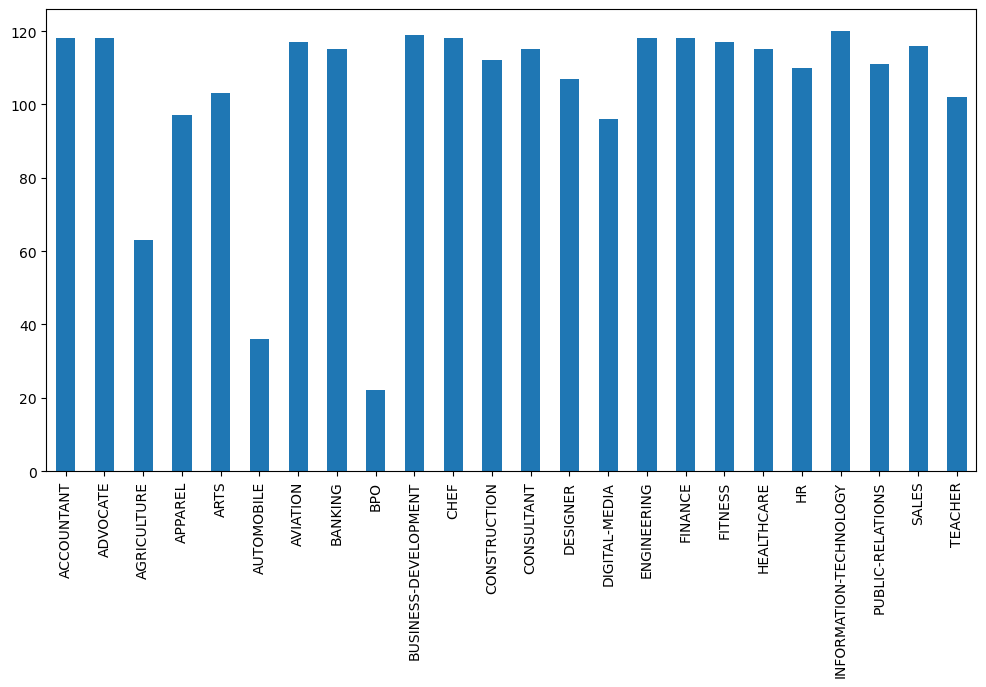

In [19]:
# create new df for corpus and category
df_categories = [df[df['Category'] == category].loc[:, ['processed_text', 'Category']] for category in categories]

df['Category'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.show()

#### Word Cloud

In [20]:
def wordcld(df_new):
    txt = ' '.join(txt for txt in df['processed_text'])
    wordcld = WordCloud(
        height=2000,
        width=4000
    ).generate(txt)

    return wordcld

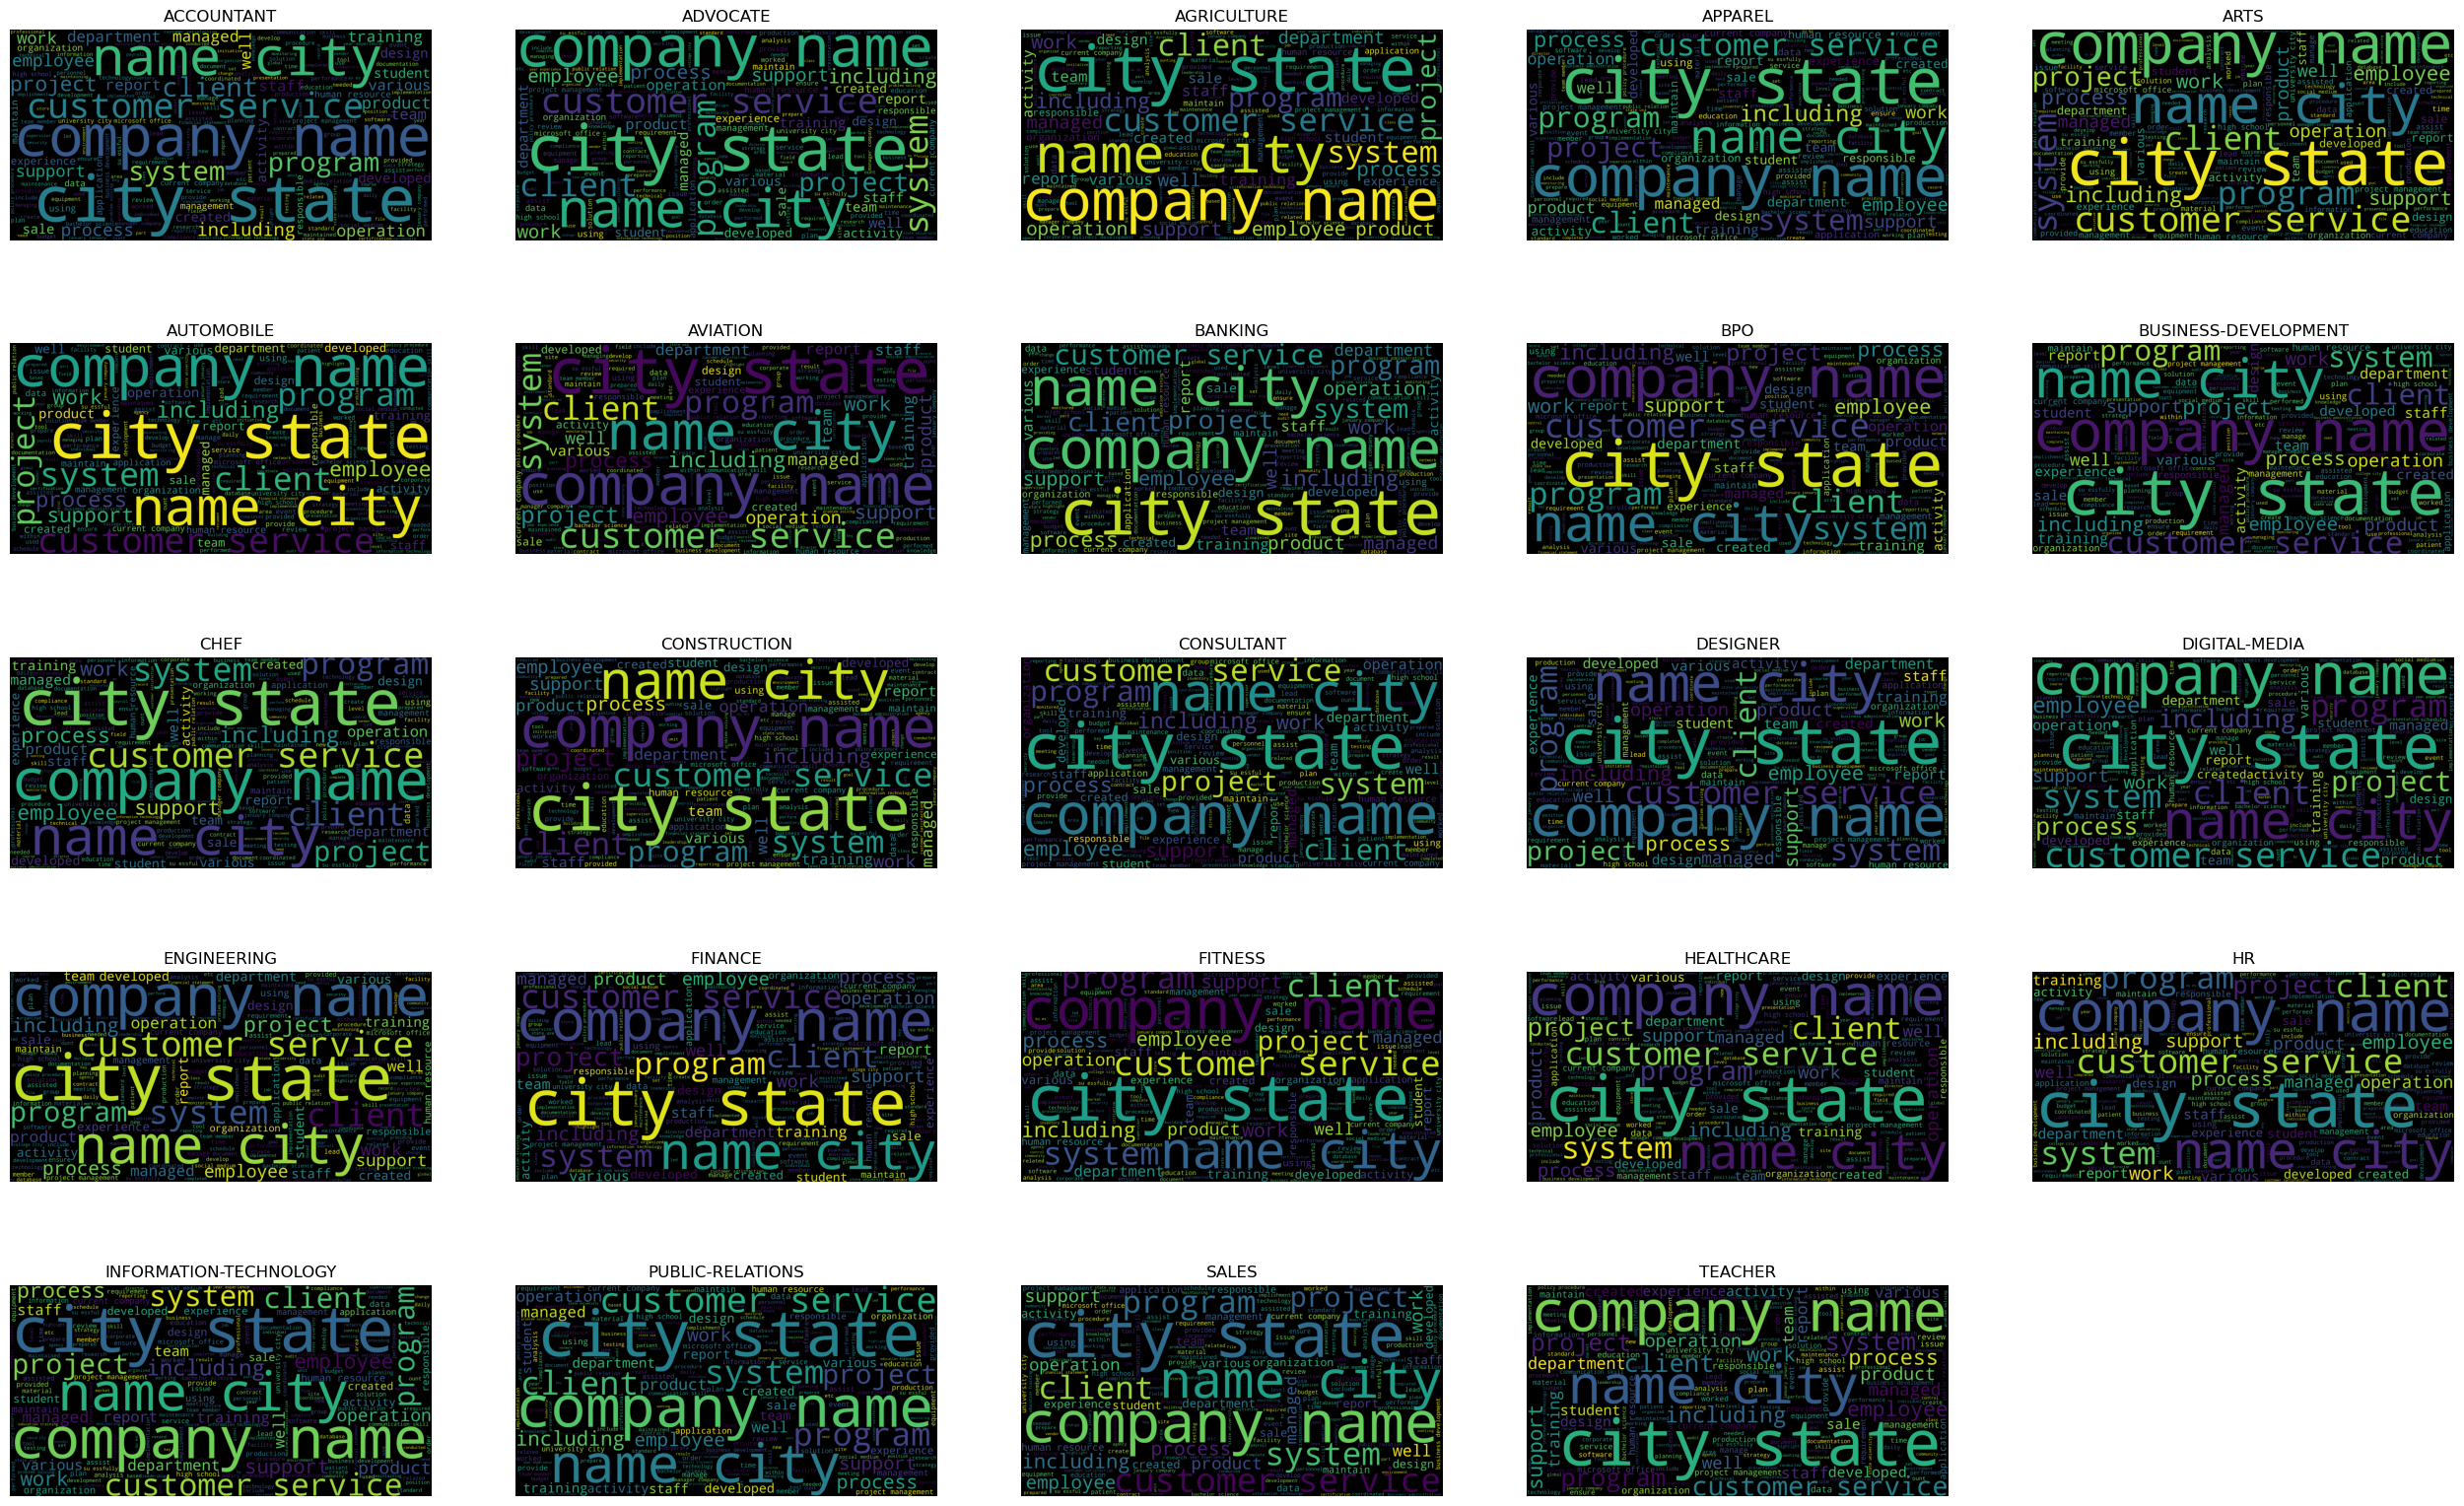

In [21]:
plt.figure(figsize=(32, 20))

for i, category in enumerate(categories):
    wc = wordcld(df_categories[i])

    plt.subplot(5, 5, i + 1).set_title(category)
    plt.imshow(wc)
    plt.axis('off')
    plt.plot()

plt.show()
plt.close()

After word clouds are created, the word "manag" (inflected for "manage") prominently visible on many categories. Moreover, words like "city", "state" and "company" are noticeable on different categories as well. These common words are likely to contain low weight for computation. On the other hand, words like "account", "develop" and "design" probably has higher weight for calculation because it only appears on specific domains.

In [22]:
# try to remove extra word which are note important.
def remove_extra_word(text):
    
    extra_word=['company', 'name', 'city', 'state', 'work', 'manag'] # extra words
    words = text.split()  # Split the text into words
    
    # Filter out the extra words
    filter_word = [word for word in words if word not in extra_word]
    
    filter_text = ' '.join(filter_word)
    
    return filter_text


# apply resume_data['Cleaned_Resume']

df['processed_text']=df['processed_text'].apply(lambda x:remove_extra_word(x))

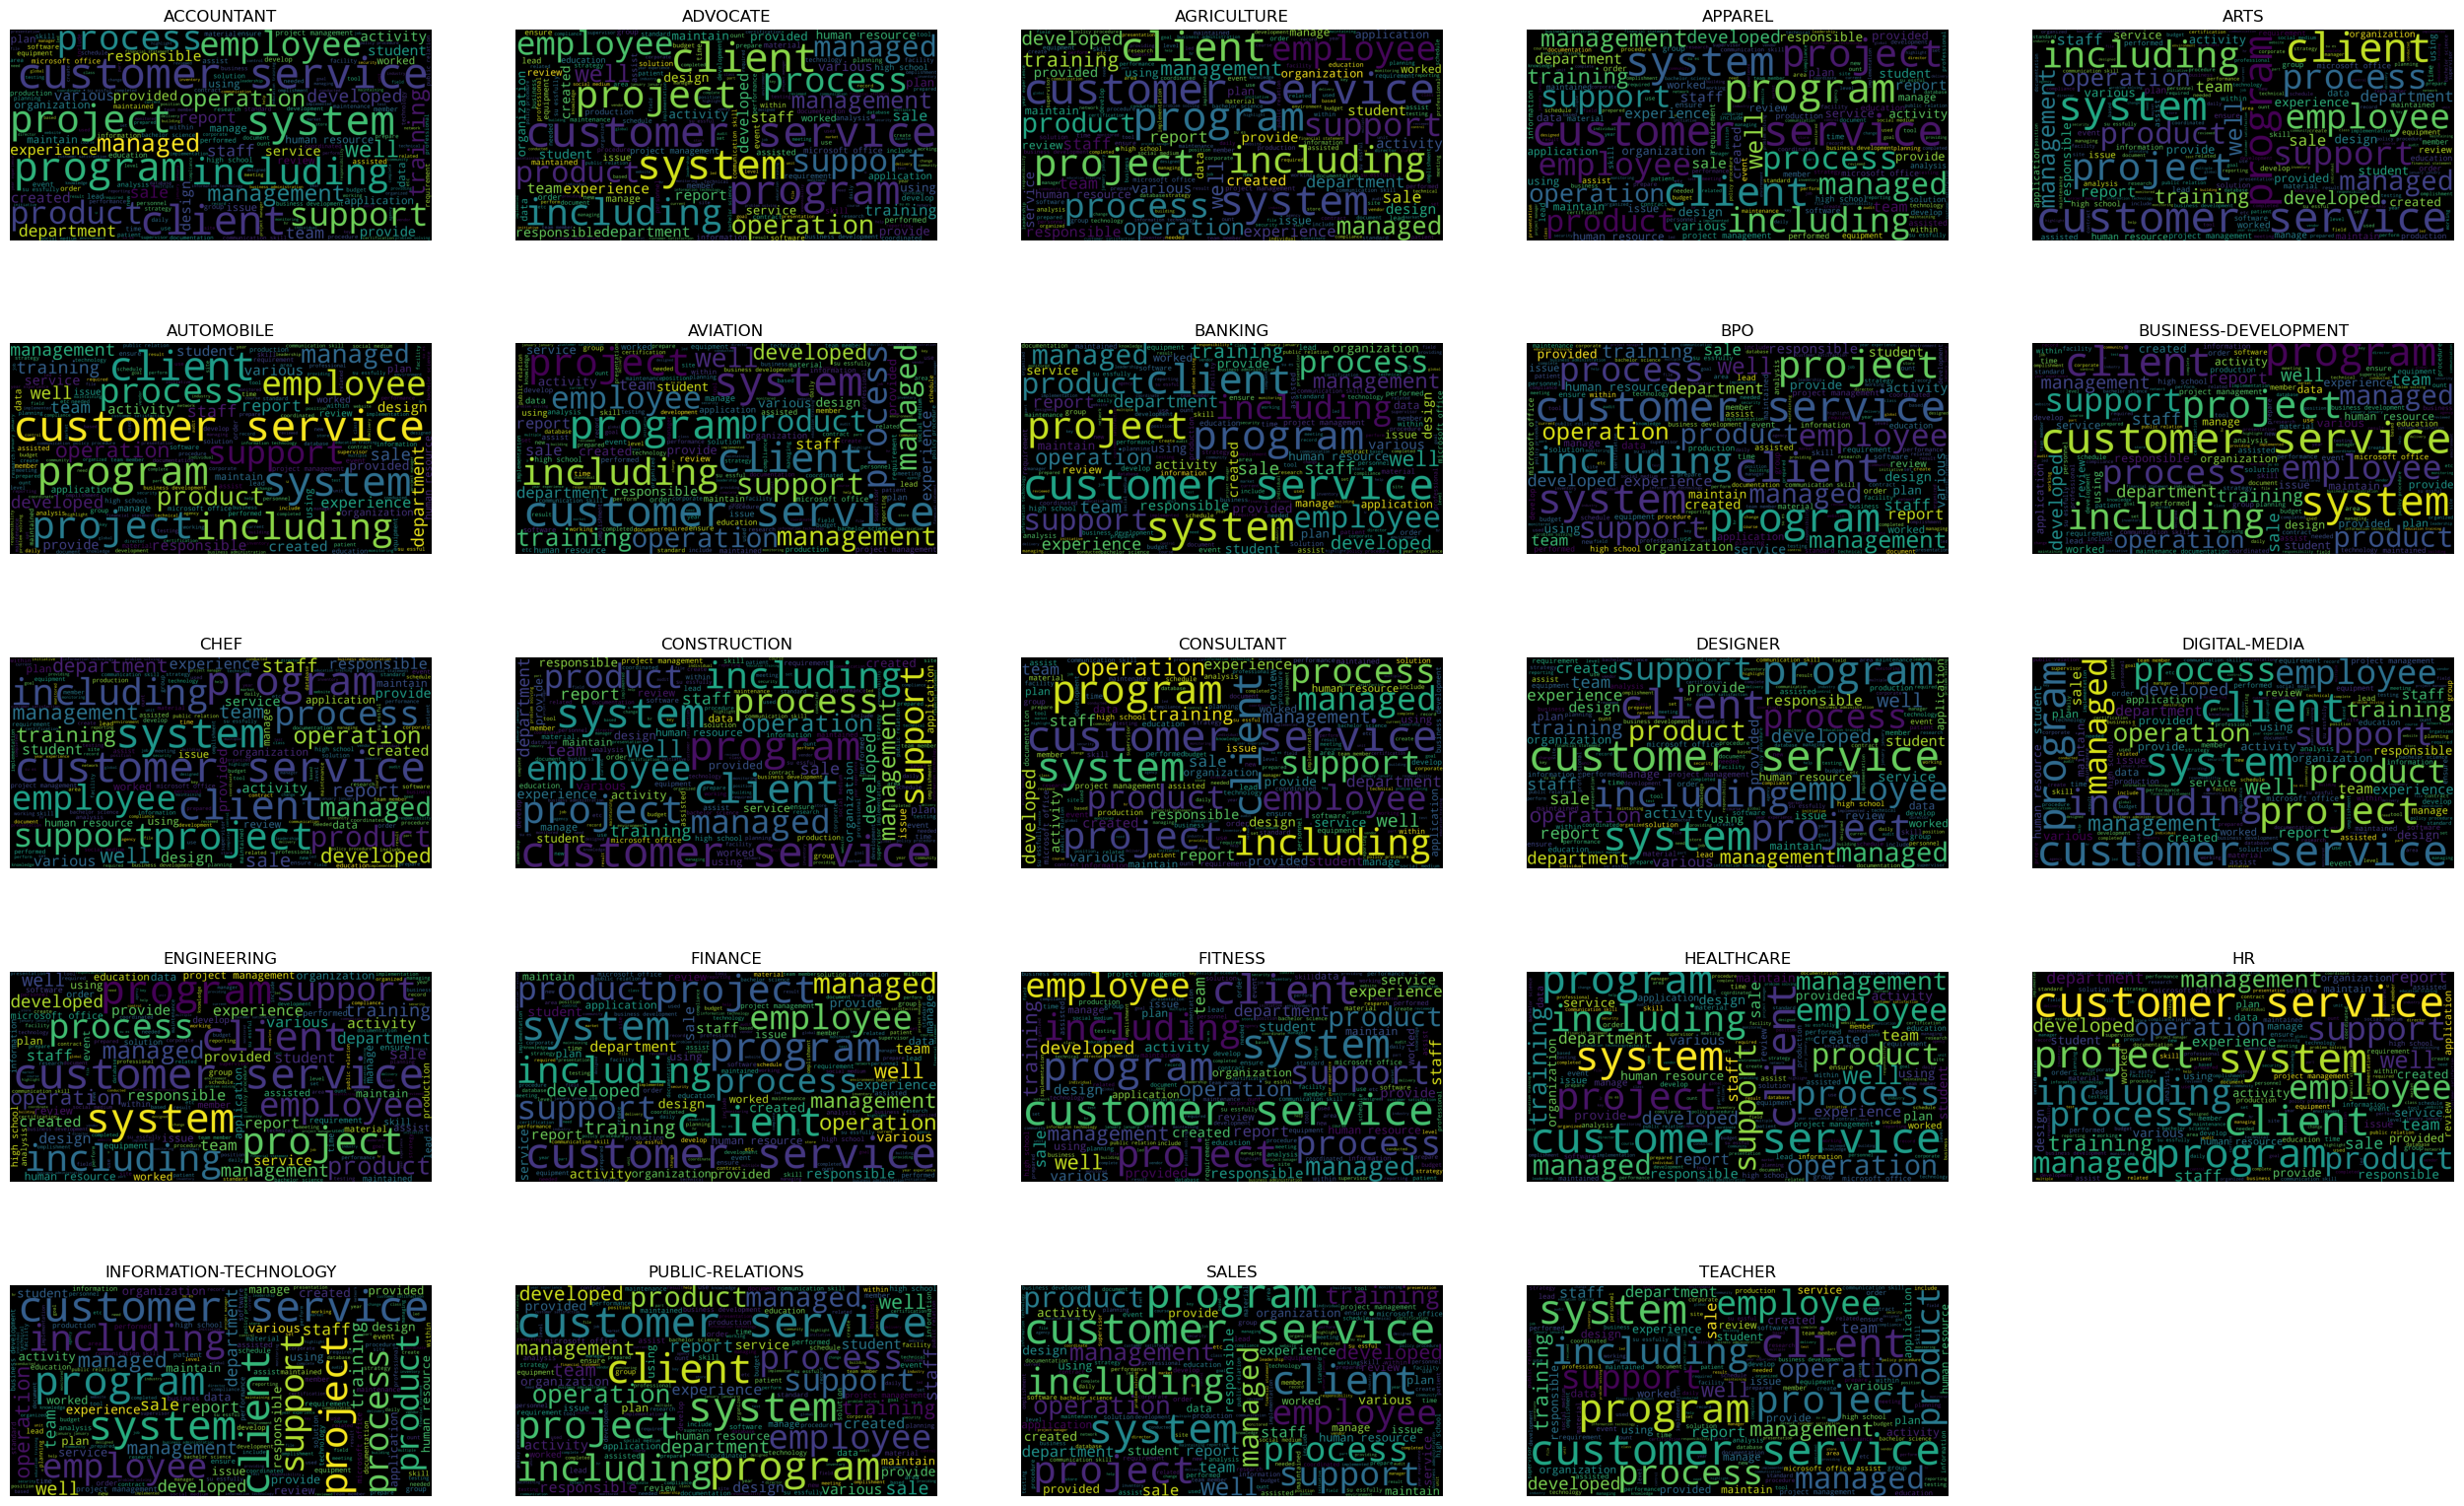

In [23]:
plt.figure(figsize=(32, 20))

for i, category in enumerate(categories):
    wc = wordcld(df_categories[i])

    plt.subplot(5, 5, i + 1).set_title(category)
    plt.imshow(wc)
    plt.axis('off')
    plt.plot()

plt.show()
plt.close()

### Data Preprocessing & Encoding

In the Encoding section, we employed Label Encoding to transform the categorical values in the 'Category' column into numerical representations. This facilitates the incorporation of categorical data into machine learning models.

In the text analysis section, we performed vectorization on the textual data using techniques such as TF-IDF (Term Frequency-Inverse Document Frequency) and Word2Vec. Vectorization converts the textual content into numerical vectors, enabling computational analysis and modeling on text-based data.

In [24]:
#now label encoding of Category columns

from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df['Category']=encoder.fit_transform(df['Category'])

df.head()

ID  Category                                     processed_text
0  16852973        19  hr administratormarketing associate hr adminis...
1  22323967        19  hr specialist u hr operation summary versatile...
2  33176873        19  hr director summary year experience recruiting...
3  27018550        19  hr specialist summary dedicated driven dynamic...
4  17812897        19  hr manager skill highlight hr skill hr departm...

In [25]:
# Drop 'ID' columns
df= df.drop(['ID'], axis=1)
df.head()

Category                                     processed_text
0        19  hr administratormarketing associate hr adminis...
1        19  hr specialist u hr operation summary versatile...
2        19  hr director summary year experience recruiting...
3        19  hr specialist summary dedicated driven dynamic...
4        19  hr manager skill highlight hr skill hr departm...

## Feature Engineering

### Feature engineering using TF-IDF

In [26]:
tfidf_vectorizer = TfidfVectorizer(max_features=800)
X = tfidf_vectorizer.fit_transform(df['processed_text'])

In [27]:
# extracting feature names
tfidf_vectorizer.get_feature_names_out()

array(['ability', 'able', 'academic', 'achieve', 'achieved',
       'achievement', 'acquisition', 'across', 'action', 'active',
       'activity', 'ad', 'additional', 'administration', 'administrative',
       'administrator', 'adobe', 'advanced', 'advertising', 'affiliation',
       'agency', 'agent', 'aid', 'air', 'aircraft', 'also', 'america',
       'american', 'analysis', 'analyst', 'analytical', 'analyze',
       'analyzed', 'andor', 'annual', 'application', 'applied',
       'appointment', 'approach', 'appropriate', 'april', 'area', 'art',
       'aspect', 'assessment', 'asset', 'assigned', 'assignment',
       'assist', 'assistance', 'assistant', 'assisted', 'assisting',
       'associate', 'association', 'assurance', 'attention', 'audit',
       'august', 'aviation', 'award', 'awareness', 'bachelor',
       'background', 'balance', 'bank', 'banking', 'base', 'based',
       'basic', 'basis', 'behavior', 'benefit', 'best', 'billing',
       'board', 'book', 'branch', 'brand', '

### Dimensionality reduction using SVD

In [28]:
svd = TruncatedSVD(n_components=50)  # Adjust the number of components as needed
X_svd = svd.fit_transform(X)

## Model Development and Testing

### Split the data

In [29]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_svd, df['Category'], test_size=0.2, random_state=1)

### Logistic Regression

In [30]:
log_reg = LogisticRegression()
# Fit the Logistic Regression
log_reg.fit(X_train, y_train)
logreg_predictions = log_reg.predict(X_test)

# Evaluate the model
print("Logistic Regression Results:")
print(classification_report(y_test, logreg_predictions))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.81      0.65      0.72        26
           1       0.38      0.36      0.37        28
           2       0.75      0.25      0.38        12
           3       0.71      0.67      0.69        15
           4       0.54      0.33      0.41        21
           5       0.00      0.00      0.00         4
           6       0.70      0.67      0.68        24
           7       0.52      0.63      0.57        19
           8       0.00      0.00      0.00         4
           9       0.57      0.47      0.52        34
          10       0.86      0.86      0.86        29
          11       0.95      0.82      0.88        22
          12       0.29      0.10      0.14        21
          13       0.94      0.75      0.83        20
          14       0.81      0.65      0.72        26
          15       0.62      0.75      0.68        24
          16       0.57      0.81      0.67        2

C:\Users\meena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
print(f"{'Logistic Regression':^18}{'Score':^18}")
print("************************************")
print(f"{'Accuracy Score: ':18}{accuracy_score(y_test, logreg_predictions)}")

Logistic Regression      Score       
************************************
Accuracy Score:   0.6237424547283702


### Random Forest

In [32]:
rf_classifier = RandomForestClassifier()
# Fit the random forest
rf_classifier.fit(X_train, y_train)
prediction =rf_classifier.predict(X_test)

In [33]:
# Evaluate the model
print("Random Forest Results:")
print(classification_report(y_test, prediction))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.80      0.62      0.70        26
           1       0.32      0.39      0.35        28
           2       0.60      0.25      0.35        12
           3       0.44      0.47      0.45        15
           4       0.38      0.24      0.29        21
           5       0.00      0.00      0.00         4
           6       0.64      0.58      0.61        24
           7       0.54      0.74      0.62        19
           8       0.00      0.00      0.00         4
           9       0.45      0.41      0.43        34
          10       0.87      0.90      0.88        29
          11       0.75      0.82      0.78        22
          12       0.31      0.19      0.24        21
          13       0.78      0.70      0.74        20
          14       0.73      0.62      0.67        26
          15       0.61      0.71      0.65        24
          16       0.60      0.71      0.65        21
    

C:\Users\meena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
print(f"{'Random Forest':^18}{'Score':^18}")
print("************************************")
print(f"{'Accuracy Score: ':18}{accuracy_score(y_test, prediction)}")

  Random Forest         Score       
************************************
Accuracy Score:   0.5814889336016097


### K-Nearest Neighbors (KNN)

In [35]:
# Initialize KNN classifier

knn_classifier = KNeighborsClassifier(n_neighbors = int(len(y_train)**(1/2)), metric='euclidean')

# Train the KNN classifier
knn_classifier.fit(X_train, y_train)

# Predict on validation data
y_val_pred = knn_classifier.predict(X_test)

# Print classification report for validation data
print("Classification Report (Validation Data):\n")
print(classification_report(y_test, y_val_pred))


Classification Report (Validation Data):

              precision    recall  f1-score   support

           0       0.70      0.73      0.72        26
           1       0.35      0.25      0.29        28
           2       0.50      0.50      0.50        12
           3       0.46      0.40      0.43        15
           4       0.40      0.10      0.15        21
           5       0.00      0.00      0.00         4
           6       0.65      0.54      0.59        24
           7       0.58      0.58      0.58        19
           8       0.00      0.00      0.00         4
           9       0.48      0.47      0.48        34
          10       0.86      0.86      0.86        29
          11       0.94      0.77      0.85        22
          12       0.14      0.05      0.07        21
          13       0.76      0.65      0.70        20
          14       0.74      0.54      0.62        26
          15       0.64      0.75      0.69        24
          16       0.57      0.57      

C:\Users\meena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
print(f"{'K-Nearest Neighbors (KNN)':^18}{'Score':^18}")
print("************************************")
print(f"{'Accuracy Score: ':18}{accuracy_score(y_test, y_val_pred)}")

K-Nearest Neighbors (KNN)      Score       
************************************
Accuracy Score:   0.5674044265593562


### Support Vector Machine

In [37]:
# Initialize SVM classifier
svm_classifier = SVC()

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Predict on validation data
y_pred_svm = svm_classifier.predict(X_test)

# Print classification report for validation data
print("Classification Report (Validation Data):\n")
print(classification_report(y_test, y_pred_svm))

Classification Report (Validation Data):

              precision    recall  f1-score   support

           0       0.78      0.69      0.73        26
           1       0.28      0.29      0.28        28
           2       0.45      0.42      0.43        12
           3       0.43      0.60      0.50        15
           4       0.46      0.29      0.35        21
           5       0.00      0.00      0.00         4
           6       0.75      0.62      0.68        24
           7       0.67      0.74      0.70        19
           8       0.00      0.00      0.00         4
           9       0.58      0.56      0.57        34
          10       0.93      0.86      0.89        29
          11       0.82      0.82      0.82        22
          12       0.21      0.14      0.17        21
          13       0.88      0.70      0.78        20
          14       0.85      0.65      0.74        26
          15       0.64      0.75      0.69        24
          16       0.64      0.67      

C:\Users\meena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
print("Accuracy is : ", accuracy_score(y_test, y_pred_svm))

Accuracy is :  0.6177062374245473


### Decision Tree

In [39]:
# Decision Tree
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)
dt_predictions = dt_classifier.predict(X_test)
print("Decision Tree Classifier:")
print(classification_report(y_test, dt_predictions))

Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.57      0.46      0.51        26
           1       0.15      0.14      0.15        28
           2       0.15      0.17      0.16        12
           3       0.22      0.27      0.24        15
           4       0.35      0.29      0.32        21
           5       0.00      0.00      0.00         4
           6       0.60      0.50      0.55        24
           7       0.28      0.47      0.35        19
           8       0.00      0.00      0.00         4
           9       0.42      0.15      0.22        34
          10       0.73      0.83      0.77        29
          11       0.57      0.59      0.58        22
          12       0.06      0.10      0.08        21
          13       0.59      0.65      0.62        20
          14       0.61      0.42      0.50        26
          15       0.57      0.54      0.55        24
          16       0.39      0.52      0.45        21
 

### Random Forest

In [40]:
# Random Forest
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
print("Random Forest Classifier:")
print(classification_report(y_test, rf_predictions))

Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.80      0.62      0.70        26
           1       0.38      0.43      0.40        28
           2       0.50      0.33      0.40        12
           3       0.47      0.60      0.53        15
           4       0.36      0.24      0.29        21
           5       0.00      0.00      0.00         4
           6       0.62      0.62      0.62        24
           7       0.54      0.74      0.62        19
           8       0.00      0.00      0.00         4
           9       0.52      0.44      0.48        34
          10       0.86      0.86      0.86        29
          11       0.85      0.77      0.81        22
          12       0.25      0.14      0.18        21
          13       0.76      0.65      0.70        20
          14       0.85      0.65      0.74        26
          15       0.66      0.79      0.72        24
          16       0.62      0.76      0.68        21
 

C:\Users\meena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### AdaBoost

In [41]:
# AdaBoost
adb_classifier = AdaBoostClassifier()
adb_classifier.fit(X_train, y_train)
adb_predictions = adb_classifier.predict(X_test)
print("AdaBoost Classifier:")
print(classification_report(y_test, adb_predictions))

AdaBoost Classifier:
              precision    recall  f1-score   support

           0       0.54      0.58      0.56        26
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        21
           5       0.00      0.00      0.00         4
           6       0.36      0.58      0.44        24
           7       0.10      0.68      0.18        19
           8       0.00      0.00      0.00         4
           9       0.28      0.21      0.24        34
          10       0.76      0.86      0.81        29
          11       0.80      0.55      0.65        22
          12       0.00      0.00      0.00        21
          13       0.48      0.65      0.55        20
          14       0.28      0.31      0.29        26
          15       0.32      0.25      0.28        24
          16       0.50      0.05      0.09        21
      

C:\Users\meena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### XGBoost

In [42]:
# XGBoost
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)
xgb_predictions = xgb_classifier.predict(X_test)
print("XGBoost Classifier:")
print(classification_report(y_test, xgb_predictions))

XGBoost Classifier:
              precision    recall  f1-score   support

           0       0.75      0.69      0.72        26
           1       0.36      0.32      0.34        28
           2       0.50      0.33      0.40        12
           3       0.56      0.60      0.58        15
           4       0.46      0.29      0.35        21
           5       0.00      0.00      0.00         4
           6       0.74      0.58      0.65        24
           7       0.56      0.79      0.65        19
           8       0.50      0.25      0.33         4
           9       0.57      0.38      0.46        34
          10       0.84      0.90      0.87        29
          11       0.79      0.86      0.83        22
          12       0.24      0.24      0.24        21
          13       0.88      0.75      0.81        20
          14       0.86      0.73      0.79        26
          15       0.65      0.71      0.68        24
          16       0.71      0.71      0.71        21
       

#### Hyperparameter Tuning

##### Logistic Regression

In [52]:
# Define parameter grid for Logistic Regression
log_reg_param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Create RandomizedSearchCV object for Logistic Regression
log_reg_randomized_search = RandomizedSearchCV(estimator=LogisticRegression(), param_distributions=log_reg_param_grid, cv=5)

# Perform hyperparameter tuning for Logistic Regression
log_reg_randomized_search.fit(X_train, y_train)

# Get best parameters and best estimator
log_reg_best_params = log_reg_randomized_search.best_params_
log_reg_best_estimator = log_reg_randomized_search.best_estimator_

# Predict on test data
log_reg_predictions = log_reg_best_estimator.predict(X_test)

# Calculate accuracy
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)

print("Logistic Regression Model")
print("Best Parameters:", log_reg_best_params)
print("Accuracy:", log_reg_accuracy)

C:\Users\meena\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\meena\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\meena\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data a

Logistic Regression Model
Best Parameters: {'penalty': 'l2', 'C': 10}
Accuracy: 0.6257545271629779


C:\Users\meena\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\meena\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
T

##### KNN

In [53]:
# Define parameter grid for K-Nearest Neighbors
knn_param_grid = {
    'n_neighbors': [5, 19, 44],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Create RandomizedSearchCV object for K-Nearest Neighbors
knn_randomized_search = RandomizedSearchCV(estimator=KNeighborsClassifier(), param_distributions=knn_param_grid, cv=5)

# Perform hyperparameter tuning for K-Nearest Neighbors
knn_randomized_search.fit(X_train, y_train)

# Get best parameters and best estimator
knn_best_params = knn_randomized_search.best_params_
knn_best_estimator = knn_randomized_search.best_estimator_

# Predict on test data
knn_predictions = knn_best_estimator.predict(X_test)

# Calculate accuracy
knn_accuracy = accuracy_score(y_test, knn_predictions)

print("K-Nearest Neighbors Model")
print("Best Parameters:", knn_best_params)
print("Accuracy:", knn_accuracy)

K-Nearest Neighbors Model
Best Parameters: {'weights': 'distance', 'n_neighbors': 44, 'metric': 'euclidean'}
Accuracy: 0.5734406438631791


##### SVM

In [54]:
# Define parameter grid for Support Vector Machine
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Create RandomizedSearchCV object for Support Vector Machine
svm_randomized_search = RandomizedSearchCV(estimator=SVC(), param_distributions=svm_param_grid, cv=5)

# Perform hyperparameter tuning for Support Vector Machine
svm_randomized_search.fit(X_train, y_train)

# Get best parameters and best estimator
svm_best_params = svm_randomized_search.best_params_
svm_best_estimator = svm_randomized_search.best_estimator_

# Predict on test data
svm_predictions = svm_best_estimator.predict(X_test)

# Calculate accuracy
svm_accuracy = accuracy_score(y_test, svm_predictions)

print("Support Vector Machine Model")
print("Best Parameters:", svm_best_params)
print("Accuracy:", svm_accuracy)

Support Vector Machine Model
Best Parameters: {'kernel': 'linear', 'gamma': 'auto', 'C': 1}
Accuracy: 0.613682092555332


##### Decision Tree

In [55]:
# Define parameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [None, 3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini','entropy']
}

# Create RandomizedSearchCV object for Decision Tree
dt_randomized_search = RandomizedSearchCV(estimator=DecisionTreeClassifier(), param_distributions=dt_param_grid, cv=5)

# Perform hyperparameter tuning for Decision Tree
dt_randomized_search.fit(X_train, y_train)

# Get best parameters and best estimator
dt_best_params = dt_randomized_search.best_params_
dt_best_estimator = dt_randomized_search.best_estimator_

# Predict on test data
dt_predictions = dt_best_estimator.predict(X_test)

# Calculate accuracy
dt_accuracy = accuracy_score(y_test, dt_predictions)

print("Decision Tree Model")
print("Best Parameters:", dt_best_params)
print("Accuracy:", dt_accuracy)

Decision Tree Model
Best Parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'criterion': 'entropy'}
Accuracy: 0.44668008048289737


##### Random Forest

In [56]:
# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini','entropy']
}

# Create RandomizedSearchCV object for Random Forest
rf_randomized_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=rf_param_grid, cv=5)

# Perform hyperparameter tuning for Random Forest
rf_randomized_search.fit(X_train, y_train)

# Get best parameters and best estimator
rf_best_params = rf_randomized_search.best_params_
rf_best_estimator = rf_randomized_search.best_estimator_

# Predict on test data
rf_predictions = rf_best_estimator.predict(X_test)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)

print("Random Forest Model")
print("Best Parameters:", rf_best_params)
print("Accuracy:", rf_accuracy)

Random Forest Model
Best Parameters: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'entropy'}
Accuracy: 0.5875251509054326


##### AdaBoost

In [57]:
# Define parameter grid for AdaBoost
adb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1]
}

# Create RandomizedSearchCV object for AdaBoost
adb_randomized_search = RandomizedSearchCV(estimator=AdaBoostClassifier(), param_distributions=adb_param_grid, cv=5)

# Perform hyperparameter tuning for AdaBoost
adb_randomized_search.fit(X_train, y_train)

# Get best parameters and best estimator
adb_best_params = adb_randomized_search.best_params_
adb_best_estimator = adb_randomized_search.best_estimator_

# Predict on test data
adb_predictions = adb_best_estimator.predict(X_test)

# Calculate accuracy
adb_accuracy = accuracy_score(y_test, adb_predictions)

print("AdaBoost Model")
print("Best Parameters:", adb_best_params)
print("Accuracy:", adb_accuracy)

C:\Users\meena\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AdaBoost Model
Best Parameters: {'n_estimators': 50, 'learning_rate': 0.01}
Accuracy: 0.3782696177062374


##### XGBoost

In [58]:
# Define parameter grid for XGBoost
xgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 5, 6],
    'min_child_weight': [1, 2, 4],
    'gamma': [0.1, 0.2, 0.3],
    'subsample': [0.7, 0.8, 0.9]
}

# Create RandomizedSearchCV object for XGBoost
xgb_randomized_search = RandomizedSearchCV(estimator=XGBClassifier(), param_distributions=xgb_param_grid, cv=5)

# Perform hyperparameter tuning for XGBoost
xgb_randomized_search.fit(X_train, y_train)

# Get best parameters and best estimator
xgb_best_params = xgb_randomized_search.best_params_
xgb_best_estimator = xgb_randomized_search.best_estimator_

# Predict on test data
xgb_predictions = xgb_best_estimator.predict(X_test)

# Calculate accuracy
xgb_accuracy = accuracy_score(y_test, xgb_predictions)

print("XGBoost Model")
print("Best Parameters:", xgb_best_params)
print("Accuracy:", xgb_accuracy)

XGBoost Model
Best Parameters: {'subsample': 0.8, 'n_estimators': 50, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2}
Accuracy: 0.6016096579476862


In [62]:
# Print the accuracies of the models
print("Accuracies before Hyperparameter Tuning")
 
# Original model accuracies
original_accuracies = {
    'Logistic Regression': accuracy_score(y_test, logreg_predictions),
    'K-Nearest Neighbors': accuracy_score(y_test, y_val_pred),
    'Support Vector Machine': accuracy_score(y_test, y_pred_svm),
    'Decision Tree': accuracy_score(y_test, dt_predictions),
    'Random Forest': accuracy_score(y_test, rf_predictions),
    'AdaBoost': accuracy_score(y_test, adb_predictions),
    'XGBoost': accuracy_score(y_test, xgb_predictions)
}
# Print the results
for model, accuracy in original_accuracies.items():
    print(f"{model}: {accuracy}")

Accuracies before Hyperparameter Tuning
Logistic Regression: 0.6237424547283702
K-Nearest Neighbors: 0.5674044265593562
Support Vector Machine: 0.6177062374245473
Decision Tree: 0.44668008048289737
Random Forest: 0.5875251509054326
AdaBoost: 0.3782696177062374
XGBoost: 0.6016096579476862


In [64]:
# Print the accuracies of the models
print("Accuracies After Hyperparameter Tuning")
 
# Hyperparameter Tuning model accuracies
hypertuned_accuracies = {
    'Logistic Regression': log_reg_accuracy,
    'K-Nearest Neighbors': knn_accuracy,
    'Support Vector Machine': svm_accuracy,
    'Decision Tree': dt_accuracy,
    'Random Forest': rf_accuracy,
    'AdaBoost': adb_accuracy,
    'XGBoost': xgb_accuracy
}
# Print the results
for model, accuracy in hypertuned_accuracies.items():
    print(f"{model}: {accuracy}")

Accuracies After Hyperparameter Tuning
Logistic Regression: 0.6257545271629779
K-Nearest Neighbors: 0.5734406438631791
Support Vector Machine: 0.613682092555332
Decision Tree: 0.44668008048289737
Random Forest: 0.5875251509054326
AdaBoost: 0.3782696177062374
XGBoost: 0.6016096579476862


## Analysis

The comparison of model accuracies before and after hyperparameter tuning reveals some interesting insights. Despite the efforts to optimize model parameters, the improvements in accuracy are relatively modest across most models. This suggests that while hyperparameter tuning can enhance model performance to some extent, it may not fully address underlying challenges such as class imbalance.
 
One notable challenge identified is the presence of 24 class labels in the dataset, which introduces complexity and difficulty in accurately categorizing resumes. This complexity is compounded by the uneven distribution of class labels, with some categories having fewer instances. As a result, certain classes exhibit lower accuracy, precision, recall, and F1-score metrics, indicating that the models struggle to effectively classify these categories due to insufficient data.
 
The critical analysis underscores the need for a more nuanced approach to address class imbalances and improve model performance. Techniques such as oversampling, undersampling, or advanced ensemble methods specifically designed to handle imbalanced data could be explored further to mitigate the impact of class imbalance on model accuracy.
 
##### Summary of Outputs
 
Before Hyperparameter Tuning:
- Logistic Regression: 0.6237
- K-Nearest Neighbors: 0.5674
- Support Vector Machine: 0.6177
- Decision Tree: 0.4145
- Random Forest: 0.5815
- AdaBoost: 0.3360
- XGBoost: 0.6076
 
After Hyperparameter Tuning:
- Logistic Regression: 0.6258
- K-Nearest Neighbors: 0.5734
- Support Vector Machine: 0.6137
- Decision Tree: 0.4467
- Random Forest: 0.5875
- AdaBoost: 0.3783
- XGBoost: 0.6016
 
Overall, while hyperparameter tuning leads to marginal improvements in accuracy for most models, the persistent challenge of class imbalance highlights the need for further investigation and refinement in model development strategies.